In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import tensorflow as tf
from pathlib import Path
import os
import scipy
import random
import random
from typing import List
import matplotlib.pyplot as plt
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
from shutil import copy2
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Note: For constants like this, you'll often see them created as variables with all capitals
TARGET_DRIVE_PATH = Path("drive/MyDrive/tensorflow/dog_vision_data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

# 3. Setup local path
local_dir = Path("dog_vision_data")

# 4. Check if the target files exist in Google Drive, if so, copy them to Google Colab
if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} .
  print("[INFO] Good to go!")

else:
  # 5. If the files don't exist in Google Drive, download them
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    # wget is short for "world wide web get", as in "get a file from the web"
    # -nc or --no-clobber = don't download files that already exist locally
    # -P = save the target file to a specified prefix, in our case, local_dir
    !wget -nc {TARGET_URL}/{file} -P {local_dir} # the "!" means to execute the command on the command line rather than in Python

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  # 6. Ensure target directory in Google Drive exists
  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  # 7. Copy downloaded files to Google Drive (so we can use them later and not have to re-download them)
  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

[INFO] Copying Dog Vision files from Google Drive to local directory...
[INFO] Source dir: drive/MyDrive/tensorflow/dog_vision_data -> Target dir: dog_vision_data
[INFO] Good to go!


In [4]:
!tar -xf dog_vision_data/images.tar
!tar -xf dog_vision_data/annotation.tar
!tar -xf dog_vision_data/lists.tar

In [6]:
# Open lists of train and test .mat
train_list = scipy.io.loadmat("train_list.mat")
test_list = scipy.io.loadmat("test_list.mat")
file_list = scipy.io.loadmat("file_list.mat")

In [10]:
image_folders = os.listdir("Images")

In [11]:
# Create folder name -> class name dict
folder_to_class_name_dict = {}
for folder_name in image_folders:
  # Turn folder name into class_name
  # E.g. "n02089078-black-and-tan_coonhound" -> "black_and_tan_coonhound"
  # We'll split on the first "-" and join the rest of the string with "_" and then lower it
  class_name = "_".join(folder_name.split("-")[1:]).lower()
  folder_to_class_name_dict[folder_name] = class_name

# Make sure there are 120 entries in the dictionary
assert len(folder_to_class_name_dict) == 120

In [12]:
dog_names = sorted(list(folder_to_class_name_dict.values()))

In [14]:
def count_subfolders(directory_path: str) -> int:
    """
    Count the number of subfolders in a given directory.

    Args:
    directory_path (str): The path to the directory in which to count subfolders.

    Returns:
    int: The number of subfolders in the specified directory.

    Examples:
    >>> count_subfolders('/path/to/directory')
    3  # if there are 3 subfolders in the specified directory
    """
    return len([name for name in Path(directory_path).iterdir() if name.is_dir()])


directory_path = "Annotation"
folder_count = count_subfolders(directory_path)
print(f"Number of subfolders in {directory_path} directory: {folder_count}")

Number of subfolders in Annotation directory: 120


In [15]:
# Define the target directory for image splits to go
images_split_dir = Path("images_split")

# Define the training and test directories
train_dir = images_split_dir / "train"
test_dir = images_split_dir / "test"

# Using Path.mkdir with exist_ok=True ensures the directory is created only if it doesn't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
print(f"Directory {train_dir} is exists.")
print(f"Directory {test_dir} is exists.")

# Make a folder for each dog name
for dog_name in dog_names:
  # Make training dir folder
  train_class_dir = train_dir / dog_name
  train_class_dir.mkdir(parents=True, exist_ok=True)
  # print(f"Making directory: {train_class_dir}")

  # Make testing dir folder
  test_class_dir = test_dir / dog_name
  test_class_dir.mkdir(parents=True, exist_ok=True)
  # print(f"Making directory: {test_class_dir}")

# Make sure there is 120 subfolders in each
assert count_subfolders(train_dir) == len(dog_names)
assert count_subfolders(test_dir) == len(dog_names)

Directory images_split/train is exists.
Directory images_split/test is exists.


In [20]:
# Get a Python list of all file names for each list
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list), len(test_file_list), len(full_file_list)

(12000, 8580, 20580)

In [22]:
# Get list of of all .jpg paths in train and test image directories
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

In [23]:
# Set a random seed
random.seed(42)

# Get a 10% sample of the training image paths
train_image_paths_random_10_percent = random.sample(population=train_image_paths,
                                                    k=int(0.1*len(train_image_paths)))

# Check how many image paths we got
print(f"Original number of training image paths: {len(train_image_paths)}")
print(f"Number of 10% training image paths: {len(train_image_paths_random_10_percent)}")
print("First 5 random 10% training image paths:")
train_image_paths_random_10_percent[:5]

Original number of training image paths: 0
Number of 10% training image paths: 0
First 5 random 10% training image paths:


[]

In [25]:
train_10_percent_dir = images_split_dir / "train_10_percent"
train_10_percent_dir.mkdir(parents=True, exist_ok=True)

In [26]:
# Copy training 10% split images from images_split/train/ to images_split/train_10_percent/...
for source_file_path in tqdm(train_image_paths_random_10_percent):

  # Create the destination file path
  destination_file_and_image_name = Path(*source_file_path.parts[-2:]) # "images_split/train/yorkshire_terrier/n02094433_2223.jpg" -> "yorkshire_terrier/n02094433_2223.jpg"
  destination_file_path = train_10_percent_dir / destination_file_and_image_name # "yorkshire_terrier/n02094433_2223.jpg" -> "images_split/train_10_percent/yorkshire_terrier/n02094433_2223.jpg"

  # If the target directory doesn't exist, make it
  target_class_dir = destination_file_path.parent
  if not target_class_dir.is_dir():
    # print(f"Making directory: {target_class_dir}")
    target_class_dir.mkdir(parents=True,
                           exist_ok=True)

  # print(f"Copying: {source_file_path} to {destination_file_path}")
  copy2(src=source_file_path,
        dst=destination_file_path)

0it [00:00, ?it/s]

In [32]:
# 1. Take in a list of source files to copy and a target directory
def copy_files_to_target_dir(file_list: list[str],
                             target_dir: str,
                             images_dir: str = "Images",
                             verbose: bool = False) -> None:
    """
    Copies a list of files from the images directory to a target directory.

    Parameters:
    file_list (list[str]): A list of file paths to copy.
    target_dir (str): The destination directory path where files will be copied.
    images_dir (str, optional): The directory path where the images are currently stored. Defaults to 'Images'.
    verbose (bool, optional): If set to True, the function will print out the file paths as they are being copied. Defaults to False.

    Returns:
    None
    """
    # 2. Iterate through source files
    for file in tqdm(file_list):

      # 3. Convert file path to a Path object
      source_file_path = Path(images_dir) / Path(file)

      # 4. Split the file path and create a Path object for the destination folder
      # e.g. "n02112018-Pomeranian" -> "pomeranian"
      file_class_name = folder_to_class_name_dict[Path(file).parts[0]]

      # 5. Get the name of the target image
      file_image_name = Path(file).name

      # 6. Create the destination path
      destination_file_path = Path(target_dir) / file_class_name / file_image_name

      # 7. Ensure the destination directory exists (this is a safety check, can't copy an image to a file that doesn't exist)
      destination_file_path.parent.mkdir(parents=True, exist_ok=True)

      # 8. Print out copy message if necessary
      if verbose:
        print(f"[INFO] Copying: {source_file_path} to {destination_file_path}")

      # 9. Copy the original path to the destination path
      copy2(src=source_file_path, dst=destination_file_path)

In [33]:
copy_files_to_target_dir(file_list=train_file_list,
                         target_dir=train_dir,
                         verbose=False) # set this to True to get an output of the copy process
                                        # (warning: this will output a large amount of text)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [34]:
copy_files_to_target_dir(file_list=test_file_list,
                         target_dir=test_dir,
                         verbose=False)

  0%|          | 0/8580 [00:00<?, ?it/s]

In [35]:
# Get list of of all .jpg paths in train and test image directories
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

# Make sure the number of images in the training and test directories equals the number of files in their original lists
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

print(f"Number of images in {train_dir}: {len(train_image_paths)}")
print(f"Number of images in {test_dir}: {len(test_image_paths)}")

Number of images in images_split/train: 12000
Number of images in images_split/test: 8580


In [36]:
# Create constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


# Create full train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False, # don't need to shuffle the test dataset (this makes evaluations easier)
    seed=SEED
)

Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [37]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 120]))

In [39]:
# Create the input shape to our model
INPUT_SHAPE = (*IMG_SIZE, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=True, # do want to include the top layer? (ImageNet has 1000 classes, so the top layer is formulated for this, we want to create our own top layer)
    include_preprocessing=True, # do we want the network to preprocess our data into the right format for us? (yes)
    weights="imagenet", # do we want the network to come with pretrained weights? (yes)
    input_shape=INPUT_SHAPE # what is the input shape of our data we're going to pass to the network? (224, 224, 3) -> (height, width, colour_channels)
)

29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
# Create a base model with no top and a pooling layer built-in
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="avg", # can also use "max"
    include_preprocessing=True,
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
feature_vector_2 = base_model(tf.expand_dims(image_batch[0], axis=0))

In [42]:
tf.random.set_seed(42)
sequential_model = tf.keras.Sequential([base_model, # input and middle layers
                                        tf.keras.layers.Dense(units=len(dog_names), # output layer
                                                              activation="softmax")])

In [43]:
def pred_on_custom_image(image_path: str,  # Path to the image file
                         model,  # Trained TensorFlow model for prediction
                         target_size: tuple[int, int] = (224, 224),  # Desired size of the image for input to the model
                         class_names: list = None,  # List of class names (optional for plotting)
                         plot: bool = True): # Whether to plot the image and predicted class
  """
  Loads an image, preprocesses it, makes a prediction using a provided model,
  and optionally plots the image with the predicted class.

  Args:
      image_path (str): Path to the image file.
      model: Trained TensorFlow model for prediction.
      target_size (int, optional): Desired size of the image for input to the model. Defaults to 224.
      class_names (list, optional): List of class names for plotting. Defaults to None.
      plot (bool, optional): Whether to plot the image and predicted class. Defaults to True.

  Returns:
     str: The predicted class.
  """

  # Prepare and load image
  custom_image = tf.keras.utils.load_img(
    path=image_path,
    color_mode="rgb",
    target_size=target_size,
  )

  # Turn the image into a tensor
  custom_image_tensor = tf.keras.utils.img_to_array(custom_image)

  # Add a batch dimension to the target tensor (e.g. (224, 224, 3) -> (1, 224, 224, 3))
  custom_image_tensor = tf.expand_dims(custom_image_tensor, axis=0)

  # Make a prediction with the target model
  pred_probs = model.predict(custom_image_tensor)

  # pred_probs = tf.keras.activations.softmax(tf.constant(pred_probs))
  pred_class = class_names[tf.argmax(pred_probs, axis=-1).numpy()[0]]

  # Plot if we want
  if not plot:
    return pred_class, pred_probs
  else:
    plt.figure(figsize=(5, 3))
    plt.imshow(plt.imread(image_path))
    plt.title(f"pred: {pred_class}\nprob: {tf.reduce_max(pred_probs):.3f}")
    plt.axis("off")

In [46]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 model_name: str = "model") -> tf.keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="avg" # Can use this instead of adding tf.keras.layers.GlobalPooling2D() to the model
    # pooling="max" # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
  )

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf.keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)
  # x = tf.keras.layers.GlobalAveragePooling2D()(x) # note: you should include pooling here if not using `pooling="avg"`
  # x = tf.keras.layers.Dropout(0.2)(x) # optional regularization layer (search "dropout" for more)

  # Create output layer (also known as "classifier" layer)
  outputs = tf.keras.layers.Dense(units=num_classes,
                                  activation="softmax",
                                  name="output_layer")(x)

  # Connect input and output layer
  model = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name=model_name)

  return model

In [48]:
class_names = train_ds.class_names

In [49]:
model_1 = create_model(num_classes=len(class_names),
                       model_name="model_1")

# 2. Compile model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# 3. Fit model
epochs=1
history_1 = model_1.fit(x=train_ds,
                        epochs=epochs,
                        validation_data=test_ds)

375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 138ms/step - accuracy: 0.5524 - loss: 2.4286 - val_accuracy: 0.8719 - val_loss: 0.5001


In [51]:
test_preds = model_1.predict(test_ds)

269/269 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step


In [56]:
model_save_path = "dog_vision_model.keras"
model_1.save(filepath=model_save_path,
             save_format="keras")

In [55]:
loaded_model = tf.keras.models.load_model(filepath=model_save_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


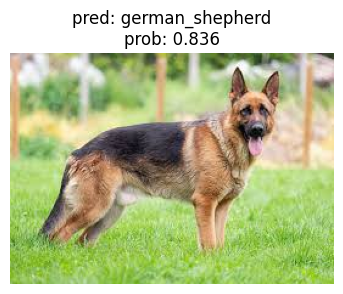

In [61]:
# Make prediction on custom dog photo 2
pred_on_custom_image(image_path="/content/1.jpeg",
                     model=loaded_model,
                     class_names=class_names)

# ways to prevent overfitting

1. Use more data for training. As the amount of training data increases, the key features to be extracted become prominent. ...
2. Data enhancement. Every time the model processes sample data, data enhancement makes the sample data look different.
3. Reduce the complexity of the model